## Подготовка данных

### Загрузка данных

Импортируем необходимые для работы библиотеки:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import sklearn.metrics as sklm  

Откроем и проанализируем файл:

In [2]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Подготовка и анализ данных

#### Работа со столбцами

Столбцы `DateCrawled`, `DateCreated`, `NumberOfPictures`, `PostalCode` и `LastSeen` не являются информативными. Удалим их:

In [4]:
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis = 1)

Приведем названия столбцов к "змеиному" регистру:

In [5]:
df.columns = df.columns.str.lower()

In [6]:
df = df.rename(columns = {
    
    'vehicletype' : 'vehicle_type',
    'registrationyear' : 'registration_year',
    'registrationmonth' : 'registration_month',
    'fueltype' : 'fuel_type',
    'notrepaired' : 'not_repaired'
      
})

#### Проверка на пропуски

Сделаем проверку на пропуски:

In [7]:
df.isna().sum()

price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
not_repaired          71154
dtype: int64

In [8]:
df

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


Данные с пропусками являются категоральными, восстановить значения не получится. Поставим на месте пропусков "заглушки" "unknown":

In [9]:
df = df.fillna("unknown")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               354369 non-null  int64 
 1   vehicle_type        354369 non-null  object
 2   registration_year   354369 non-null  int64 
 3   gearbox             354369 non-null  object
 4   power               354369 non-null  int64 
 5   model               354369 non-null  object
 6   kilometer           354369 non-null  int64 
 7   registration_month  354369 non-null  int64 
 8   fuel_type           354369 non-null  object
 9   brand               354369 non-null  object
 10  not_repaired        354369 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


#### Проверка на дубликаты

Проверим данные на дубликаты:

In [11]:
df.duplicated().sum()

27543

Удалим дубликаты в этих данных:

In [12]:
df = df.drop_duplicates().reset_index(drop = True)

#### Провека на верный тип данных

Проверим данные на соответствие их своему типу данных:

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326826 entries, 0 to 326825
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               326826 non-null  int64 
 1   vehicle_type        326826 non-null  object
 2   registration_year   326826 non-null  int64 
 3   gearbox             326826 non-null  object
 4   power               326826 non-null  int64 
 5   model               326826 non-null  object
 6   kilometer           326826 non-null  int64 
 7   registration_month  326826 non-null  int64 
 8   fuel_type           326826 non-null  object
 9   brand               326826 non-null  object
 10  not_repaired        326826 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.4+ MB


Все данные соответствуют своим типам данных

#### Проверка на аномалии

Сделаем проверку данных на аномалии:

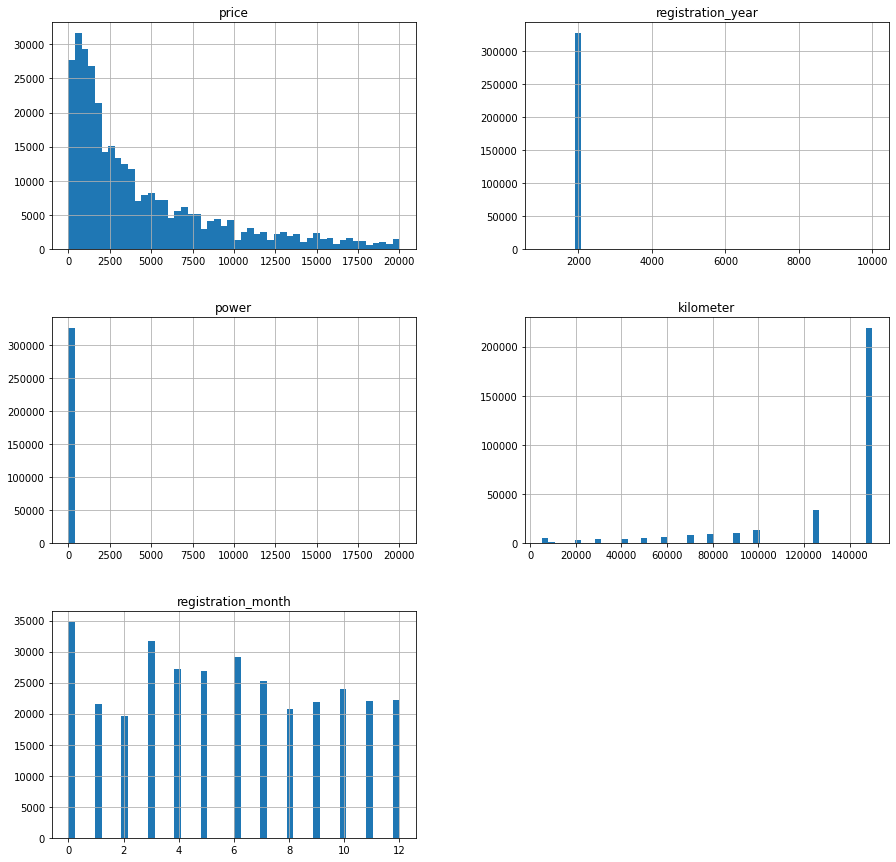

In [14]:
df.hist(bins = 50, figsize = (15, 15));

Обратим внимание на столбцы: 'registration_year', 'power'

Столбец 'registration_year':

In [15]:
df['registration_year'].describe()

count    326826.000000
mean       2004.230985
std          91.120018
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

Довольно странно выглядят минимальная и максимальная даты регистрации. Выведем значения с годом регистрации менее 1950:

In [16]:
df.query('registration_year < 1950').sort_values(by = 'registration_year')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
220600,65,unknown,1000,unknown,0,unknown,5000,1,unknown,sonstige_autos,unknown
58886,80,unknown,1000,unknown,0,unknown,5000,0,unknown,volkswagen,unknown
241079,12500,unknown,1000,unknown,200,golf,5000,0,unknown,volkswagen,unknown
64859,1300,unknown,1000,auto,0,unknown,5000,6,petrol,sonstige_autos,unknown
69917,500,unknown,1000,unknown,0,golf,5000,0,unknown,volkswagen,unknown
...,...,...,...,...,...,...,...,...,...,...,...
278624,17800,coupe,1947,unknown,0,other,150000,0,unknown,ford,unknown
61952,17500,wagon,1948,manual,0,unknown,60000,6,petrol,sonstige_autos,no
231829,0,unknown,1948,unknown,0,unknown,5000,0,unknown,opel,unknown
254066,8800,coupe,1948,manual,100,unknown,10000,7,petrol,sonstige_autos,unknown


Обратившись к официальным источникам, определим, что информация о автомобилях, зарегистрированных ранее 1930 года, является ложной. Удалим строки с данными автомобилями:

In [17]:
df = df.query('registration_year > 1930').reset_index(drop = True)

Однако и максимальная дата регистрации не является правдоподобной. Выведем значения с годом регистрации более 2019:

In [18]:
df.query('registration_year > 2019').sort_values(by = 'registration_year')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
26279,800,unknown,2066,unknown,0,zafira,5000,0,gasoline,opel,unknown
18120,300,unknown,2200,unknown,0,twingo,5000,12,unknown,renault,unknown
208818,100,unknown,2222,unknown,0,unknown,5000,0,unknown,sonstige_autos,unknown
237368,0,unknown,2222,unknown,0,unknown,5000,0,unknown,mercedes_benz,unknown
117438,700,unknown,2290,unknown,0,laguna,5000,0,unknown,renault,unknown
...,...,...,...,...,...,...,...,...,...,...,...
242059,50,unknown,9999,unknown,0,other,10000,0,unknown,hyundai,unknown
190581,850,unknown,9999,unknown,0,unknown,10000,0,unknown,mazda,unknown
49279,50,unknown,9999,unknown,0,911,10000,0,unknown,porsche,unknown
251234,150,unknown,9999,unknown,0,unknown,10000,0,unknown,sonstige_autos,unknown


Обратившись к официальным источникам, определим, что информация о автомобилях, зарегистрированных после 2016 года, является ложной. Удалим строки с данными автомобилями:

In [19]:
df = df.query('registration_year <= 2016').reset_index(drop = True)

Столбец 'power':

In [20]:
df['power'].describe()

count    312829.000000
mean        111.212858
std         192.878733
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

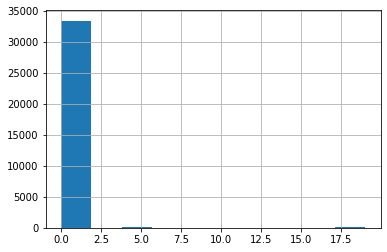

In [21]:
df.query('power < 20')['power'].hist(bins = 10);

Заменим строки со значением мощности автомобилей менее 20 л.с. на медианное значение мощности:

In [22]:
power_more_20_median = round(df.query('power > 20')['power'].median())

In [23]:
for index in range(len(df['power'])):
    if df.loc[index, 'power'] <= 0:
        df.loc[index, 'power'] = power_more_20_median

Проверим цены на автомобили:

In [24]:
df['price'].describe()

count    312829.000000
mean       4461.056389
std        4551.539672
min           0.000000
25%        1050.000000
50%        2750.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

Непонятен тот факт, почему автомобили стоят от 0 евро. Выведем значения с ценой менее 20 евро:

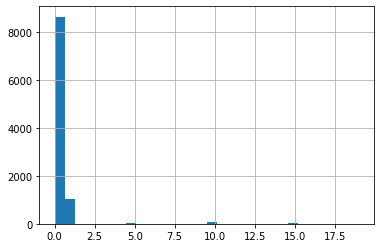

In [25]:
df[df['price'] < 20]['price'].hist(bins = 30);

Действительно, наблюдаются очень низкие цены, в основном, это единичные случаи. Кроме значений 0 и 1 евро - они массовые. Вероятно, это недостоверные данные. Удалим строки с этими значениями:

In [26]:
df = df.query('price > 1').reset_index(drop = True)

#### Определение корреляции между значениями

Определим, какие зависимости есть между таргетами (price) и остальными признаками:

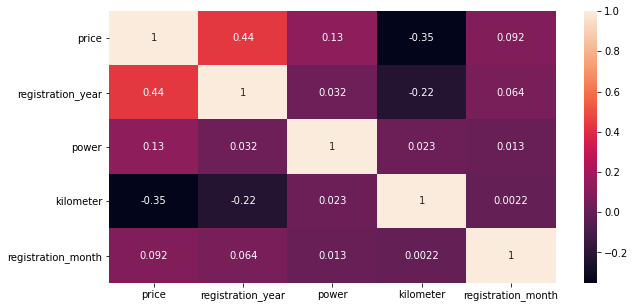

In [27]:
plt.figure(figsize = (10, 5))
sns.heatmap(df.corr(), annot = True);

Из полученной тепловой карты прослеживается средняя прямая зависисимость между годом регистрации автомобиля и его ценой, а также слабая обратная - между кол-вом пройденных километров и ценой

## Обучение моделей

### Подготовка выборки для обучения моделей

Преобразуем категоральные параметры техникой Ordinal Encoder. Выделим эти переменные в отдельный датасет:

In [28]:
df_encoder = df.copy()
df_encoder = df_encoder[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']]

Применим технику Ordinal Encoder:

In [29]:
encoder = OrdinalEncoder()
df_encoder_update = pd.DataFrame(encoder.fit_transform(df_encoder), columns = df_encoder.columns)

In [30]:
df_encoder_update

,vehicle_type,gearbox,model,fuel_type,brand,not_repaired
0,7.0,1.0,116.0,6.0,38.0,1.0
1,2.0,1.0,228.0,2.0,1.0,2.0
2,6.0,0.0,117.0,2.0,14.0,1.0
3,5.0,1.0,116.0,6.0,38.0,0.0
4,5.0,1.0,101.0,2.0,31.0,0.0
...,...,...,...,...,...,...
303169,4.0,1.0,140.0,6.0,30.0,2.0
303170,7.0,2.0,228.0,7.0,33.0,1.0
303171,1.0,0.0,106.0,6.0,32.0,0.0
303172,0.0,1.0,224.0,2.0,38.0,0.0


Удалим из исходного датасета столбцы с категоральными переменными и объединим его с обновленным датасетом:

In [31]:
df = df.drop(['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired'], axis = 1)
df = df.join(df_encoder_update, how = 'right')

In [32]:
df.head(10)

,price,registration_year,power,kilometer,registration_month,vehicle_type,gearbox,model,fuel_type,brand,not_repaired
0,480,1993,110,150000,0,7.0,1.0,116.0,6.0,38.0,1.0
1,18300,2011,190,125000,5,2.0,1.0,228.0,2.0,1.0,2.0
2,9800,2004,163,125000,8,6.0,0.0,117.0,2.0,14.0,1.0
3,1500,2001,75,150000,6,5.0,1.0,116.0,6.0,38.0,0.0
4,3600,2008,69,90000,7,5.0,1.0,101.0,2.0,31.0,0.0
5,650,1995,102,150000,10,4.0,1.0,11.0,6.0,2.0,2.0
6,2200,2004,109,150000,8,1.0,1.0,8.0,6.0,25.0,0.0
7,14500,2014,125,30000,8,0.0,1.0,60.0,6.0,10.0,1.0
8,999,1998,101,150000,0,5.0,1.0,116.0,7.0,38.0,1.0
9,2000,2004,105,150000,12,4.0,1.0,10.0,6.0,19.0,0.0


Для обучения модели разделим значения на таргеты (price) и остальные признаки на тестовую и валидационную выборки:

In [33]:
features_train, features_valid, target_train, target_valid = tts(df.drop('price', axis = 1), 
                                                                 df['price'], test_size = 0.2, random_state = 12345)

Из обучающей выборки выделим тестовую:

In [34]:
features_train, features_test, target_train, target_test = tts(features_train, 
                                                                 target_train, test_size = 0.25, random_state = 12345)

### Обучение модели на RF

Проведем обучение модели на RF:

In [35]:
model_RF = RandomForestRegressor(random_state = 12345)

Введем перебор гиперпараметров:

In [36]:
parameters_RF = {  
    
    'max_depth' : [2, 4, 6],
    'n_estimators' : [10, 20, 30]
    
}

Определим наиболее подходящие гиперпараметры модели:

In [37]:
%%time

model_RF_param = GridSearchCV(estimator = model_RF, param_grid = parameters_RF, cv = 3, 
                              scoring = 'neg_root_mean_squared_error')
model_RF_param.fit(features_train, target_train)

print(model_RF_param.best_params_)

{'max_depth': 6, 'n_estimators': 20}
CPU times: user 40.5 s, sys: 52.6 ms, total: 40.6 s
Wall time: 40.6 s


Обучим модель с учетом подобранных гиперпараметров:

In [38]:
%%time

model_RF_update = RandomForestRegressor(random_state = 12345, n_estimators = 20, max_depth = 6)
model_RF_update.fit(features_train, target_train)
model_RF_update_pred = model_RF_update.predict(features_valid)

CPU times: user 3.12 s, sys: 4 ms, total: 3.13 s
Wall time: 3.13 s


Определим качество модели по метрике R2:

In [39]:
sklm.r2_score(target_valid, model_RF_update_pred)

0.7502898672105782

Определим качество модели по метрике RMSE:

In [40]:
sklm.mean_squared_error(target_valid, model_RF_update_pred) ** 0.5

2274.2723785989283

### Обучение модели на LightGBM

Проведем обучение модели на LightGBM:

In [41]:
model_LGBM = LGBMRegressor(random_state = 12345)

In [42]:
%%time

model_LGBM.fit(features_train, target_train)
model_LGBM_pred = model_LGBM.predict(features_valid)

CPU times: user 4.63 s, sys: 54.2 ms, total: 4.68 s
Wall time: 4.65 s


Определим качество модели по метрике R2:

In [43]:
sklm.r2_score(target_valid, model_LGBM_pred)

0.85478247543378

Определим качество модели по метрике RMSE:

In [44]:
sklm.mean_squared_error(target_valid, model_LGBM_pred) ** 0.5

1734.3386746038695

Введем перебор гиперпараметров:

In [45]:
parameters_LGBM = {  
    'max_depth' : [1, 2, 3, 4, 5, 6, 7],
    'boosting_type' : ['gbdt', 'dart']
    
}

Определим наиболее подходящие гиперпараметры модели:

In [46]:
%%time

model_LGBM_param = GridSearchCV(estimator = model_LGBM, param_grid = parameters_LGBM, cv = 3, 
                                scoring = 'neg_root_mean_squared_error')
model_LGBM_param.fit(features_train, target_train)

print(model_LGBM_param.best_params_)

{'boosting_type': 'gbdt', 'max_depth': 7}
CPU times: user 4min 19s, sys: 1.54 s, total: 4min 20s
Wall time: 4min 22s


Обучим модель с учетом подобранных гиперпараметров:

In [47]:
%%time

model_LGBM_update = LGBMRegressor(random_state = 12345, boosting_type = 'gbdt', max_depth = 7)
model_LGBM_update.fit(features_train, target_train)
model_LGBM_update_pred = model_LGBM_update.predict(features_valid)

CPU times: user 5.54 s, sys: 37.1 ms, total: 5.58 s
Wall time: 5.68 s


Определим качество модели по метрике R2:

In [48]:
sklm.r2_score(target_valid, model_LGBM_update_pred)

0.8532667402074837

Определим качество модели по метрике RMSE:

In [49]:
sklm.mean_squared_error(target_valid, model_LGBM_update_pred) ** 0.5

1743.3664216159725

## Анализ моделей

### Определение времени обучения модели RF

Определим время обучения модели RF:

In [50]:
%%time

model_RF_final = RandomForestRegressor(random_state = 12345, n_estimators = 20, max_depth = 6)
model_RF_final.fit(features_train, target_train)

CPU times: user 3.17 s, sys: 5.12 ms, total: 3.18 s
Wall time: 3.21 s


RandomForestRegressor(max_depth=6, n_estimators=20, random_state=12345)

Определим время предсказания модели RF:

In [51]:
%%time

model_RF_final_pred = model_RF_final.predict(features_valid)

CPU times: user 52.5 ms, sys: 27 µs, total: 52.5 ms
Wall time: 60.9 ms


Определим качество модели по метрике R2:

In [52]:
sklm.r2_score(target_valid, model_RF_final_pred)

0.7502898672105782

Определим качество модели по метрике RMSE:

In [53]:
sklm.mean_squared_error(target_valid, model_RF_final_pred) ** 0.5

2274.2723785989283

### Определение времени обучения модели LightGBM

Определим время обучения модели LightGBM при поиске гиперпараметров:

In [54]:
%%time

model_LGBM_final = LGBMRegressor(random_state = 12345, boosting_type = 'gbdt', max_depth = 7)
model_LGBM_final.fit(features_train, target_train)

CPU times: user 3.88 s, sys: 6.4 ms, total: 3.89 s
Wall time: 3.88 s


LGBMRegressor(max_depth=7, random_state=12345)

Определим время предсказания модели LightGBM при поиске гиперпараметров:

In [55]:
%%time

model_LGBM_final_pred = model_LGBM_final.predict(features_valid)

CPU times: user 447 ms, sys: 3.41 ms, total: 451 ms
Wall time: 491 ms


Определим качество модели по метрике R2:

In [56]:
sklm.r2_score(target_valid, model_LGBM_final_pred)

0.8532667402074837

Определим качество модели по метрике RMSE:

In [57]:
sklm.mean_squared_error(target_valid, model_LGBM_final_pred) ** 0.5

1743.3664216159725

Определим время обучения модели LightGBM без поиска гиперпараметров:

In [58]:
%%time

model_LGBM_final_no_search = LGBMRegressor(random_state = 12345)
model_LGBM_final_no_search.fit(features_train, target_train)

CPU times: user 5.81 s, sys: 21.3 ms, total: 5.83 s
Wall time: 5.88 s


LGBMRegressor(random_state=12345)

Определим время предсказания модели LightGBM без поиска гиперпараметров:

In [59]:
%%time

model_LGBM_final_no_search_pred = model_LGBM_final_no_search.predict(features_valid)

CPU times: user 428 ms, sys: 0 ns, total: 428 ms
Wall time: 491 ms


Определим качество модели по метрике R2:

In [60]:
sklm.r2_score(target_valid, model_LGBM_final_no_search_pred)

0.85478247543378

Определим качество модели по метрике RMSE:

In [61]:
sklm.mean_squared_error(target_valid, model_LGBM_final_no_search_pred) ** 0.5

1734.3386746038695

Таким образом, мы получили следующие результаты:

1. Модель RF работает с заданной точностью, метрики RMSE - 2274.27 (менее 2500), R2 - 0.75

2. Модель LightGBM без определения оптимальных гиперпараметров работает с заданной точностью, метрики RMSE - 1734.34 (менее 2500), R2 - 0.8548

3. Модель LightGBM с определением оптимальных гиперпараметров работает с заданной точностью, метрики RMSE - 1743.36 (менее 2500), R2 - 0.8533

Можем сделать несколько выводов:
1. Качество модели LightGBM выше, чем у RF
2. Качество модели LightGBM без поиска гиперпараметров выше, чем с поиском
3. Время обучения модели LightGBM с поиском гиперпараметров меньше, чем без него

Таким образом, лучшей моделью примем LightGBM.

## Тестирование

Протестируем лучшую модель - LightGBM - на тестовой выборке и определим качество модели. Основная и определяющая метрика качества - RMSE. Дополнительно также определим метрику R2

In [62]:
model_LGBM_test_pred = model_LGBM_final.predict(features_test)

Определим качество модели по метрике RMSE:

In [63]:
sklm.mean_squared_error(target_test, model_LGBM_test_pred) ** 0.5

1736.0647061601771

Определим качество модели по метрике R2:

In [64]:
sklm.r2_score(target_test, model_LGBM_test_pred)

0.855454656929315

Качество модели практически не снизилось, подходит под критерий не менее 2500

## Выводы

В ходе выполнения проекта были проведены: подготовка и анализ данных, обучение моделей, анализ данных.

Во время подготовки и анализа данных были удалены неинформативные столбцы, неверные данные, дубликаты, заполнены пропуски, были проверены верные типы данных, аномалии в данных, а также определены корреляции между данными: из тепловой карты прослеживается средняя прямая зависисимость между годом регистрации автомобиля и его ценой, а также слабая обратная - между кол-вом пройденных километров и ценой.

Во время обучения модели были проведены обучения на RF и LightGBM. Результаты оказались следующими:

1. Модель RF работает с заданной точностью, метрики RMSE - 2286.54 (менее 2500), R2 - 0.7476

2. Модель LightGBM без определения оптимальных гиперпараметров работает с заданной точностью, метрики RMSE - 1726.75 (менее 2500), R2 - 0.856

3. Модель LightGBM с определением оптимальных гиперпараметров работает с заданной точностью, метрики RMSE - 1771.68 (менее 2500), R2 - 0.84846

Во время анализа модели было определено время, за которое обучаются модели:
1. Модель RF обучается примерно за 3.27 секунд
2. Модель LightGBM без определения оптимальных гиперпараметров обучается примерно за 6.37 секунд
3. Модель LightGBM с определением оптимальных гиперпараметров обучается примерно за 4.37 секунд

Во время тестирования лучшей модели (LightGBM) было определено, что качество модели не упало, RSME = 1736.06 - менее 2500

Таким образом, можно сделать вывод о том, что наиболее эффективной является модель LightGBM.